In [72]:
!{sys.executable} -m pip install info_gain

You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
import sys
import csv
import math
import random
import operator
import time
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from random import seed, shuffle, randrange

from info_gain import info_gain
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import normalize
import time

In [74]:
df = pd.read_csv("./census-income_10percentData.csv")

In [75]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,<=50K
2,23,Local-gov,190709,Assoc-acdm,12,Never-married,Protective-serv,Not-in-family,White,Male,0,0,52,United-States,<=50K
3,53,Self-emp-not-inc,88506,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
4,47,Self-emp-inc,109832,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,53,Local-gov,155314,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,>50K
3253,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
3254,45,State-gov,103406,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1977,60,United-States,>50K
3255,67,?,182378,Bachelors,13,Married-civ-spouse,?,Husband,White,Male,9386,0,60,United-States,>50K


In [76]:
# replacing dashes in column names with underscores
df.columns = [c.replace('-', '_') for c in df.columns]
df.rename(columns = {'class':'income_class'}, inplace = True)

In [77]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,<=50K
2,23,Local-gov,190709,Assoc-acdm,12,Never-married,Protective-serv,Not-in-family,White,Male,0,0,52,United-States,<=50K
3,53,Self-emp-not-inc,88506,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
4,47,Self-emp-inc,109832,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,<=50K


In [78]:
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Local-gov', 'Self-emp-inc',
       'Private', '?', 'Federal-gov', 'Without-pay'], dtype=object)

In [79]:
df['income_class'].unique()

array(['<=50K', '>50K'], dtype=object)

In [80]:
df['occupation'].unique()

array(['Adm-clerical', 'Farming-fishing', 'Protective-serv',
       'Prof-specialty', 'Exec-managerial', 'Machine-op-inspct',
       'Tech-support', 'Other-service', 'Craft-repair',
       'Transport-moving', 'Sales', 'Handlers-cleaners', '?',
       'Priv-house-serv'], dtype=object)

In [81]:
df['relationship'].unique()

array(['Not-in-family', 'Own-child', 'Husband', 'Unmarried',
       'Other-relative', 'Wife'], dtype=object)

In [82]:
df['marital_status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced', 'Widowed',
       'Separated', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [83]:
# find columns that has ?

columns_with_question = []
for column in df.columns:
    if len(df[df[column] == "?"]):
        columns_with_question.append(column)
print("Columns has '?': %s" % columns_with_question)

Columns has '?': ['workclass', 'occupation', 'native_country']


## Getting rid of '?' values

In [84]:
df[df['workclass'] == '?']

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
33,17,?,202521,11th,7,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
35,32,?,115745,Some-college,10,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K
46,55,?,105138,HS-grad,9,Married-civ-spouse,?,Wife,Asian-Pac-Islander,Female,0,0,40,United-States,<=50K
52,17,?,80077,11th,7,Never-married,?,Own-child,White,Female,0,0,20,United-States,<=50K
54,25,?,202480,Assoc-acdm,12,Never-married,?,Other-relative,White,Male,0,0,45,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3161,57,?,300104,5th-6th,3,Married-civ-spouse,?,Husband,White,Male,7298,0,84,United-States,>50K
3201,39,?,361838,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,6,United-States,>50K
3227,27,?,251854,Bachelors,13,Married-civ-spouse,?,Wife,Black,Female,0,0,35,?,>50K
3253,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K


'?'s are in the following columns:

- workclass
- occupation
- native_country

Since those don't have numeric values, we can't replace the '?'s with a mean, so we will replace them with the mode (the value appearing most often in each of the given columns)

In [85]:
most_often = df.mode(dropna=True)
most_often

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,Private,102130,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [86]:
most_often['occupation'][0]

'Prof-specialty'

In [87]:
# replace columns with ? to most often
for column in columns_with_question:
    df[df[column] == "?"].apply(lambda x: most_often[column][0] )

df.loc[(df.workclass == '?'), "workclass"] = df.mode(dropna=True)['workclass'][0]
df.loc[(df.occupation == '?'), "occupation"] = df.mode(dropna=True)['occupation'][0]
df.loc[(df.native_country == '?'), "native_country"] = df.mode(dropna=True)['native_country'][0]

In [88]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,<=50K
2,23,Local-gov,190709,Assoc-acdm,12,Never-married,Protective-serv,Not-in-family,White,Male,0,0,52,United-States,<=50K
3,53,Self-emp-not-inc,88506,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
4,47,Self-emp-inc,109832,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,53,Local-gov,155314,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,>50K
3253,35,Private,320084,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,55,United-States,>50K
3254,45,State-gov,103406,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1977,60,United-States,>50K
3255,67,Private,182378,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,9386,0,60,United-States,>50K


## Information Gain

Using this package -- https://pypi.org/project/info-gain/

https://github.com/Thijsvanede/info_gain

In [89]:
# ig_age  = info_gain.info_gain(df['age'].tolist(), df['income_class'].tolist())       # information gain
# iv  = info_gain.intrinsic_value(df['age'].tolist(), df['income_class'].tolist()) # intrinsic value
# igr = info_gain.info_gain_ratio(df['age'].tolist(), df['income_class'].tolist()) # information gain ratio

igs = {}
for column in df:
    if column == 'income_class':
        continue
    ig  = info_gain.info_gain(df[column].tolist(), df['income_class'].tolist())
    igs[column] = ig
    print("IG(" + str(column) + "): %s" % ig)

print()

sorted_igs = sorted(igs.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_igs[:2])

IG(age): 0.07868354342024597
IG(workclass): 0.014844898303145393
IG(fnlwgt): 0.5222886086315057
IG(education): 0.06409179586687075
IG(education_num): 0.06409179586687075
IG(marital_status): 0.1147377359864643
IG(occupation): 0.055601714063640895
IG(relationship): 0.11839751234770657
IG(race): 0.00518854681815395
IG(sex): 0.025000749576874037
IG(capital_gain): 0.08243445402217187
IG(capital_loss): 0.03529628068440388
IG(hours_per_week): 0.05051684552841085
IG(native_country): 0.012698314298945745

[('fnlwgt', 0.5222886086315057), ('relationship', 0.11839751234770657)]


Therefore, top two information gains:

- fnlwgt
- relationship

In [90]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,<=50K
2,23,Local-gov,190709,Assoc-acdm,12,Never-married,Protective-serv,Not-in-family,White,Male,0,0,52,United-States,<=50K
3,53,Self-emp-not-inc,88506,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
4,47,Self-emp-inc,109832,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,53,Local-gov,155314,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,>50K
3253,35,Private,320084,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,55,United-States,>50K
3254,45,State-gov,103406,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1977,60,United-States,>50K
3255,67,Private,182378,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,9386,0,60,United-States,>50K


In [91]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income_class'],
      dtype='object')

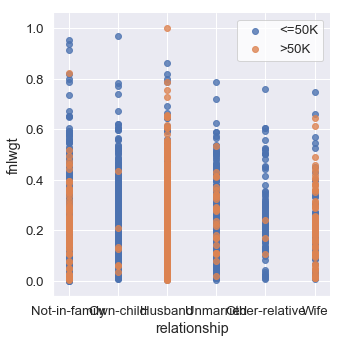

In [153]:
# this is the code for the scatter plot
# input features for x and y
sns.lmplot(x="relationship", y="fnlwgt", data=df, fit_reg=False, hue='income_class', legend=False)
st = sns.axes_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 8})
plt.legend(loc='upper right')



## Converting nominal values to numeric

In [93]:
columns_to_factorize = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income_class']
factorized_columns = []
for column in columns_to_factorize:
    column_f = column + '_f'
    df[column_f] = pd.factorize(df[column])[0]
    factorized_columns.append(column_f)


In [94]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,income_class,workclass_f,education_f,marital_status_f,occupation_f,relationship_f,race_f,sex_f,native_country_f,income_class_f
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,...,<=50K,0,0,0,0,0,0,0,0,0
1,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,...,<=50K,1,1,0,1,1,0,0,0,0
2,23,Local-gov,190709,Assoc-acdm,12,Never-married,Protective-serv,Not-in-family,White,Male,...,<=50K,2,2,0,2,0,0,0,0,0
3,53,Self-emp-not-inc,88506,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,<=50K,1,0,1,3,2,0,0,0,0
4,47,Self-emp-inc,109832,HS-grad,9,Divorced,Exec-managerial,Not-in-family,White,Male,...,<=50K,3,1,2,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,53,Local-gov,155314,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,...,>50K,2,1,1,0,5,0,1,0,1
3253,35,Private,320084,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,...,>50K,4,0,1,3,5,0,1,0,1
3254,45,State-gov,103406,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,>50K,0,0,1,4,2,0,0,0,1
3255,67,Private,182378,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,>50K,4,0,1,3,2,0,0,0,1


In [95]:
feature_columns = ['age', 'fnlwgt', 'education_num'] + factorized_columns
features_df = df[feature_columns]

In [96]:
features_df

,age,fnlwgt,education_num,workclass_f,education_f,marital_status_f,occupation_f,relationship_f,race_f,sex_f,native_country_f,income_class_f
0,39,77516,13,0,0,0,0,0,0,0,0,0
1,25,176756,9,1,1,0,1,1,0,0,0,0
2,23,190709,12,2,2,0,2,0,0,0,0,0
3,53,88506,13,1,0,1,3,2,0,0,0,0
4,47,109832,9,3,1,2,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3252,53,155314,9,2,1,1,0,5,0,1,0,1
3253,35,320084,13,4,0,1,3,5,0,1,0,1
3254,45,103406,13,0,0,1,4,2,0,0,0,1
3255,67,182378,13,4,0,1,3,2,0,0,0,1


In [97]:
ct = df['income_class'].value_counts().reset_index()
ct.columns = ['income_class', 'Count']
print(ct)

# # Too many 0's, have to remove some

# count_0 = 0
# for index, row in df.iterrows():
#     if row['income_class'] == 0:
#         count_0 += 1
#     if row['income_class'] == 0 and count_0 > 785:
#         df = df.drop(index)

# ct1 = df['income_class'].value_counts().reset_index()
# ct1.columns = ['income_class', 'Count']
# print(ct1)

  income_class  Count
0        <=50K   2472
1         >50K    785


## Min-Max Rescaling

In [98]:
def main_max_rescaling(df, columns):
    for col in columns:
        pt_min = df[col].min()
        pt_max = df[col].max()
        df[col] = (df[col] - pt_min) / (pt_max - pt_min)

In [99]:
main_max_rescaling(df, feature_columns)

In [100]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,income_class,workclass_f,education_f,marital_status_f,occupation_f,relationship_f,race_f,sex_f,native_country_f,income_class_f
0,0.301370,State-gov,0.077816,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,...,<=50K,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.109589,Self-emp-not-inc,0.210472,HS-grad,0.533333,Never-married,Farming-fishing,Own-child,White,Male,...,<=50K,0.166667,0.066667,0.000000,0.083333,0.2,0.0,0.0,0.0,0.0
2,0.082192,Local-gov,0.229123,Assoc-acdm,0.733333,Never-married,Protective-serv,Not-in-family,White,Male,...,<=50K,0.333333,0.133333,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0
3,0.493151,Self-emp-not-inc,0.092506,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,<=50K,0.166667,0.000000,0.166667,0.250000,0.4,0.0,0.0,0.0,0.0
4,0.410959,Self-emp-inc,0.121013,HS-grad,0.533333,Divorced,Exec-managerial,Not-in-family,White,Male,...,<=50K,0.500000,0.066667,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,0.493151,Local-gov,0.181810,HS-grad,0.533333,Married-civ-spouse,Adm-clerical,Wife,White,Female,...,>50K,0.333333,0.066667,0.166667,0.000000,1.0,0.0,1.0,0.0,1.0
3253,0.246575,Private,0.402061,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,White,Female,...,>50K,0.666667,0.000000,0.166667,0.250000,1.0,0.0,1.0,0.0,1.0
3254,0.383562,State-gov,0.112423,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,...,>50K,0.000000,0.000000,0.166667,0.333333,0.4,0.0,0.0,0.0,1.0
3255,0.684932,Private,0.217987,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Husband,White,Male,...,>50K,0.666667,0.000000,0.166667,0.250000,0.4,0.0,0.0,0.0,1.0


# Charts

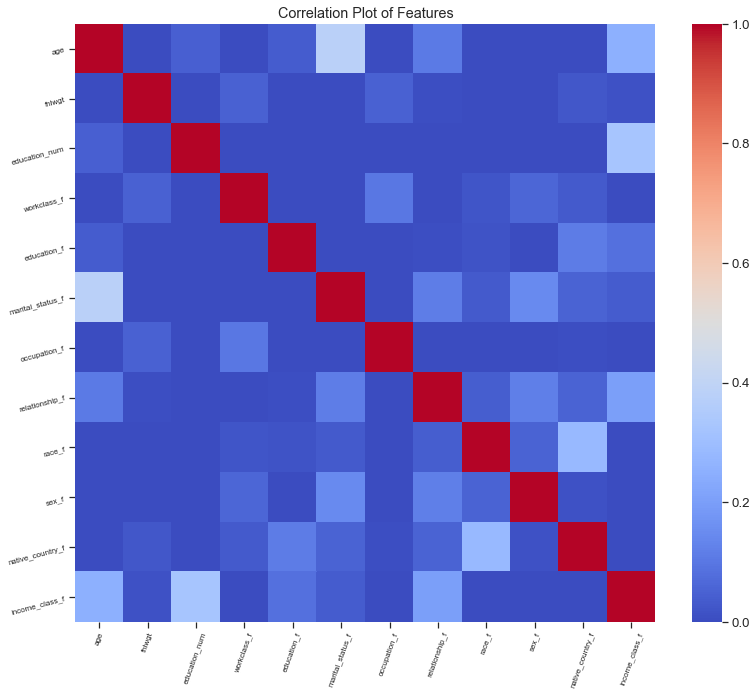

In [101]:
# correlation plot
#feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
#       'marital_status', 'occupation', 'relationship', 'race', 'sex',
#       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
#       'income_class']
mean_corr = df[feature_columns].corr()
fig=plt.figure(figsize=(13,11))
g1 = sns.heatmap(mean_corr, cmap='coolwarm', vmin=0, vmax=1)
g1.set_xticklabels(g1.get_xticklabels(), rotation=70, fontsize=8)
g1.set_yticklabels(g1.get_yticklabels(), rotation=15, fontsize=8)
plt.title("Correlation Plot of Features")
plt.show()

# which column depends on which column more

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


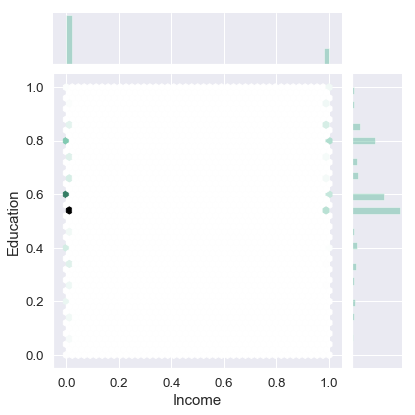

In [102]:
sns.set(font_scale=1.2)
j=sns.jointplot(df['income_class_f'], df['education_num'], kind='hex', color="#4CB391")
j.set_axis_labels('Income', 'Education', fontsize=15)
plt.show()

# don't need this


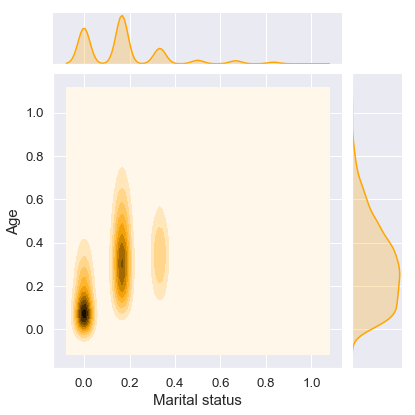

In [103]:
sns.set(font_scale=1.2)
j=sns.jointplot(df['marital_status_f'], df['age'], kind='kde', color="orange")
j.set_axis_labels('Marital status', 'Age', fontsize=15)
plt.show()

In [104]:
# PCA
data = df[feature_columns].to_numpy()
scaler1 = StandardScaler()
scaler1.fit(data)
feature_scaled = scaler1.transform(data)

pca1 = PCA(n_components=4)
pca1.fit(feature_scaled)
feature_scaled_pca = pca1.transform(feature_scaled)
print("shape of the scaled and 'PCA'ed features: ", np.shape(feature_scaled_pca))

shape of the scaled and 'PCA'ed features:  (3257, 4)


In [105]:
feat_var = np.var(feature_scaled_pca, axis=0)
feat_var_rat = feat_var/(np.sum(feat_var))

print ("Variance Ratio of the 4 Principal Components Ananlysis: ", feat_var_rat)

Variance Ratio of the 4 Principal Components Ananlysis:  [0.30374693 0.25620752 0.22297694 0.21706862]


In [106]:
pca_df = pd.DataFrame(pca1.components_,columns=feature_columns,index = ['PC-1','PC-2','PC-3','PC-4'])
pca_df


,age,fnlwgt,education_num,workclass_f,education_f,marital_status_f,occupation_f,relationship_f,race_f,sex_f,native_country_f,income_class_f
PC-1,0.513716,-0.112797,0.356947,-0.297841,0.079742,0.308010,-0.251421,0.269210,-0.049284,-0.077252,-0.017014,0.511519
PC-2,0.165682,-0.074028,-0.329841,0.126489,0.118561,0.449719,-0.082811,0.257636,0.392958,0.423600,0.407935,-0.229070
PC-3,0.067887,0.184188,-0.128750,0.045168,0.294741,-0.096525,0.446805,0.019540,0.290166,-0.551509,0.431132,0.269090
PC-4,-0.370328,-0.018131,0.428281,-0.137898,0.118955,-0.398058,-0.411629,-0.003104,0.404347,0.162546,0.347872,0.084298


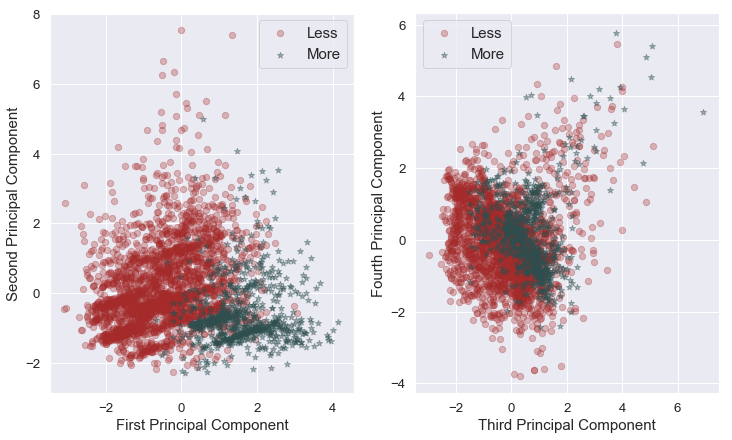

In [107]:
labels = df["income_class_f"].to_numpy()
feature_scaled_pca_X0 = feature_scaled_pca[:, 0]
feature_scaled_pca_X1 = feature_scaled_pca[:, 1]
feature_scaled_pca_X2 = feature_scaled_pca[:, 2]
feature_scaled_pca_X3 = feature_scaled_pca[:, 3]

colordict = {0:'brown', 1:'darkslategray'}
piclabel = {0:'Less', 1:'More'}
markers = {0:'o', 1:'*'}
alphas = {0:0.3, 1:0.4}

fig = plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
for l in np.unique(labels):
    ix = np.where(labels==l)
    plt.scatter(feature_scaled_pca_X0[ix], feature_scaled_pca_X1[ix], c=colordict[l], 
               label=piclabel[l], s=40, marker=markers[l], alpha=alphas[l])
plt.xlabel("First Principal Component", fontsize=15)
plt.ylabel("Second Principal Component", fontsize=15)

plt.legend(fontsize=15)

plt.subplot(1,2,2)
for l1 in np.unique(labels):
    ix1 = np.where(labels==l1)
    plt.scatter(feature_scaled_pca_X2[ix1], feature_scaled_pca_X3[ix1], c=colordict[l1], 
               label=piclabel[l1], s=40, marker=markers[l1], alpha=alphas[l1])
plt.xlabel("Third Principal Component", fontsize=15)
plt.ylabel("Fourth Principal Component", fontsize=15)

plt.legend(fontsize=15)
plt.show()

## Stratified n-fold-cross-validation

In [108]:
# use shuffle False and fixed random_state to have constant result
# DELETE
skf = StratifiedKFold(n_splits=10, shuffle = False, random_state = 1)
t = df.income_class_f
for train_index, test_index in skf.split(np.zeros(len(t)), t):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [109]:
# don't use the first one
def cross_validation(columns):
    selected_df = df[columns]
    x = df.to_numpy()
    y = df["income_class_f"].to_numpy()

    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        yield x_train, x_test, y_train, y_test

        
def cross_validation_num(x, y):
    skf = StratifiedKFold(n_splits=10, shuffle = False, random_state = 2)
    data = []
    for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        data.append((x_train, x_test, y_train, y_test))
    return data

In [110]:
len(train)

2932

In [111]:
len(test)

325

In [112]:
# df[["class", "workclass"]]

## Linear Soft-Margin SVM

### Just using top two features -- fnlwgt and relationship

Score = the mean accuracy on the given test data and labels.

F1 = 2 * (precision * recall) / (precision + recall)

https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9 --> F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

In [113]:
#training
def train(x_train, x_test, y_train, y_test, kernel="linear", c=1.0):
    print("Train data set with size: %s kernel %s C %s" % (len(x_train), kernel, c))
    print("Test size: %s" % len(x_test))
    current = time.time()
    clf = svm.SVC(kernel=kernel, C=c, cache_size=len(x_train))
    clf.fit(x_train, y_train)
    y_score = clf.score(x_test, y_test)
    y_result = clf.predict(x_test)
    average_precision = average_precision_score(y_test, y_result)
    precision, recall, _ = precision_recall_curve(y_test, y_result)
    f1 = f1_score(y_test, y_result, average='weighted')
    var = explained_variance_score(y_test, y_result)  
    print("Score: %s" % y_score)
    print("Average precision score: %s" % average_precision)
    print("Precision: %s" % precision)
    print("Recall: %s" % recall)
    print("F1: %s" % f1)
    print("Variance: %s" % var)
    elapsed = time.time() - current 
    print("======================== Time: %s" % elapsed)
    return (clf, y_score)

def train_crosss(kernel, c):
    best = None
    best_score = 0.0
    for x_train, x_test, y_train, y_test in data:
        print("Start with set %s" % len(x_train))
        clf, y_score = train(x_train, x_test, y_train, y_test, kernel, c)
        if best_score < y_score:
            best = clf
            best_score = y_score
        
    print("Best score: %s" % best_score)
    return best

In [114]:
Y_train_top2 = df[['income_class_f']].copy().values.tolist()

In [115]:
feature = df[['relationship_f', 'fnlwgt']].to_numpy()
labels = df['income_class_f'].to_numpy()

In [116]:
feature

array([[0.        , 0.0778157 ],
       [0.2       , 0.21047158],
       [0.        , 0.22912281],
       ...,
       [0.4       , 0.11242332],
       [0.4       , 0.21798661],
       [1.        , 0.35907585]])

In [117]:
labels

array([0., 0., 0., ..., 1., 1., 1.])

In [118]:
data = cross_validation_num(feature, labels)

In [119]:
best = train_crosss("linear", 0.1)

Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327
Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 0.11842989921569824
Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327
Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 0.07725858688354492
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.07011008262634277
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.09684514999389648
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.06862115859985352
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.0641930103302002
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.06752514839172363
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.07285094261169434
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.07893610000610352
Start with set 2932
Train data set with size: 2932 kernel linear C 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [120]:
fignum = 1
def draw_svm(clf, x, y):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    
    # plot the parallels to the separating hyperplane that pass through the
    # support vectors (margin away from hyperplane in direction
    # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
    # 2-d.
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(10, 6))
    plt.clf()
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(x[:, 0], x[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolors='k')

    plt.axis('tight')
    #x_min = np.amin(x) - 1 #-4.8
    #x_max = np.amax(x) + 1#4.2
    #y_min = np.amin(x) - 1 #-6
    #y_max = np.amax(x) + 1#6
    x_mins = np.amin(x, axis=0)
    x_maxs = np.amax(x, axis=0)
    
    x_min = min(x_mins[0], np.amin(xx))
    x_max = max(x_maxs[0], np.amax(xx))
    y_min = min(x_mins[1], np.amin(yy), np.amin(yy_up), np.amin(yy_down))
    y_max = max(x_maxs[1], np.amax(yy), np.amax(yy_up), np.amax(yy_down))
    
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

    delta_x = (x_max - x_min) / 30
    delta_y = (y_max - y_min) / 30
    plt.xlim(x_min - delta_x, x_max + delta_x)
    plt.ylim(y_min - delta_y, y_max + delta_y)

    plt.xticks(())
    plt.yticks(())

In [121]:
def draw_svm2(clf, X, Y):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    # =========
    #b = clf.support_vectors_[0]
    #yy_down = a * xx + (b[1] - a * b[0])
    #b = clf.support_vectors_[-1]
    #yy_up = a * xx + (b[1] - a * b[0])
    # =========
    
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum)
    plt.clf()
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=80, facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolors='k')

    plt.axis('tight')
    
    x_mins = np.amin(X, axis=0)
    x_maxs = np.amax(X, axis=0)
    
    x_min = min(x_mins[0], np.amin(xx))
    x_max = max(x_maxs[0], np.amax(xx))
    y_min = min(x_mins[1], np.amin(yy), np.amin(yy_up), np.amin(yy_down))
    y_max = max(x_maxs[1], np.amax(yy), np.amax(yy_up), np.amax(yy_down))
    
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)
    
    delta_x = (x_max - x_min) / 30
    delta_y = (y_max - y_min) / 30
    plt.xlim(x_min - delta_x, x_max + delta_x)
    plt.ylim(y_min - delta_y, y_max + delta_y)

    plt.xticks(())
    plt.yticks(())
    
    plt.show()

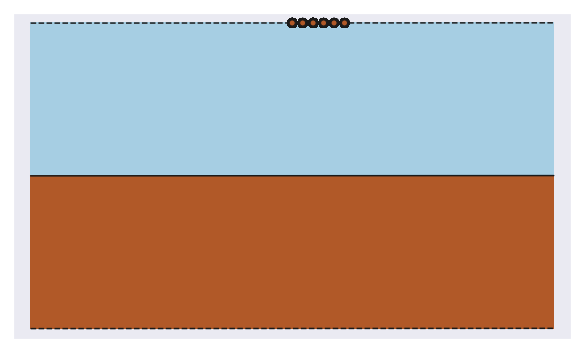

In [122]:
x_train, x_test, y_train, y_test = data[0]
draw_svm(best, x_train, y_train)

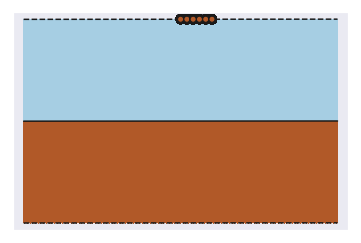

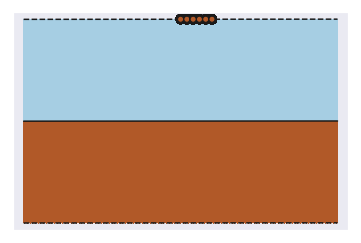

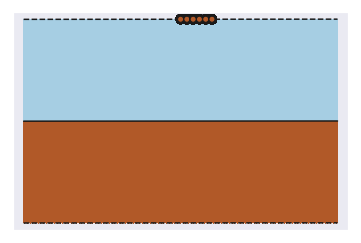

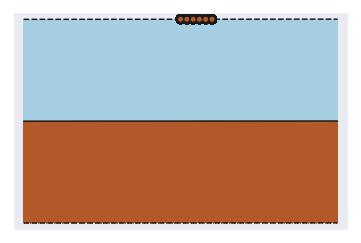

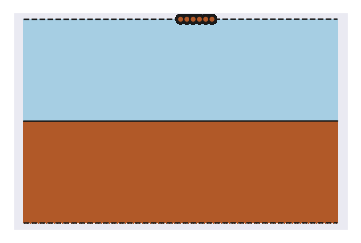

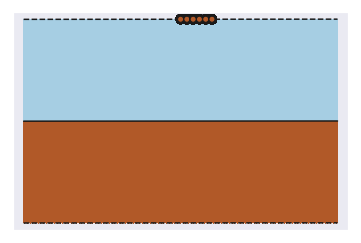

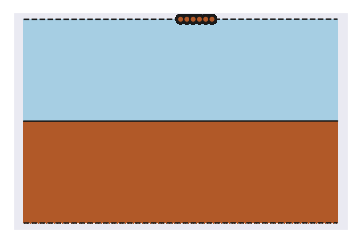

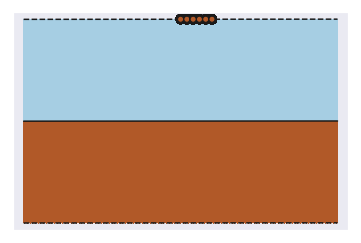

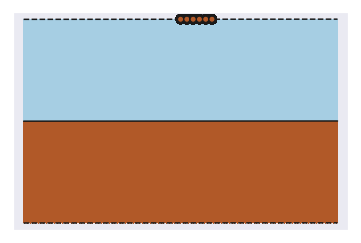

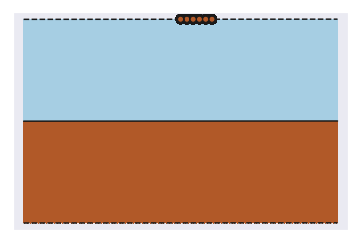

In [123]:
for x_train, x_test, y_train, y_test in data:
    draw_svm2(best, x_train, y_train)

## Increase C

In [124]:
best = train_crosss("linear", 1000)
# stays the same as with c 0.1

Start with set 2930
Train data set with size: 2930 kernel linear C 1000
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 37.00256586074829
Start with set 2930
Train data set with size: 2930 kernel linear C 1000
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 39.54854464530945
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 43.576114892959595
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 38.725950956344604
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 41.470974922180176
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 31.510292053222656
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 48.13824486732483
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 43.44383883476257
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 38.72108817100525
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 31.742671012878418
Best score: 0.76


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Try age and education

In [125]:
feature = df[['education_f', 'age']].to_numpy()
labels = df['income_class_f'].to_numpy()

In [126]:
data = cross_validation_num(feature, labels)

In [127]:
best = train_crosss("linear", 0.1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327
Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 0.06814908981323242
Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327
Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 0.07822394371032715
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.06928300857543945
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.05865788459777832
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.05373382568359375
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in l

Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.05691170692443848
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.06290102005004883
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.0663900375366211
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.07446503639221191
Best score: 0.76


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [128]:
best = train_crosss("linear", 100)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Start with set 2930
Train data set with size: 2930 kernel linear C 100
Test size: 327
Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 0.09664320945739746
Start with set 2930
Train data set with size: 2930 kernel linear C 100
Test size: 327
Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 0.08515667915344238
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.10906028747558594
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.10192489624023438
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.0891871452331543
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.08953404426574707
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.11424708366394043
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.10797286033630371
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.10095071792602539
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.09105682373046875
Best score: 0.76


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


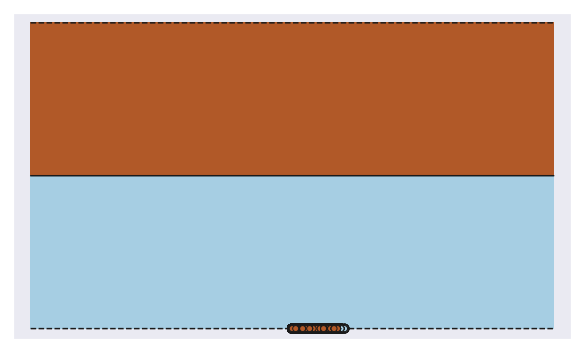

In [129]:
x_train, x_test, y_train, y_test = data[0]
draw_svm(best, x_train, y_train)

## All features

In [130]:
all_columns = [x for x in feature_columns if x != 'income_class_f']
feature = df[all_columns].to_numpy()
labels = df['income_class_f'].to_numpy()

In [131]:
data = cross_validation_num(feature, labels)

In [132]:
best = train_crosss("linear", 0.1)
# Best score: 0.8287461773700305

Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327
Score: 0.7981651376146789
Average precision score: 0.3632135151489221
Precision: [0.24159021 0.84210526 1.        ]
Recall: [1.         0.20253165 0.        ]
F1: 0.7472693255244147
Variance: 0.08217639853001191
======================== Time: 0.10207724571228027
Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327
Score: 0.8287461773700305
Average precision score: 0.45815214819976174
Precision: [0.24159021 0.92592593 1.        ]
Recall: [1.        0.3164557 0.       ]
F1: 0.7948657041283349
Variance: 0.20334830543078775
======================== Time: 0.10298609733581543
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326
Score: 0.7914110429447853
Average precision score: 0.3511671973285703
Precision: [0.24233129 0.72       1.        ]
Recall: [1.        0.2278481 0.       ]
F1: 0.7475353337719555
Variance: 0.013375698252447554
========

In [133]:
best = train_crosss("linear", 100)
# Best score: 0.8256880733944955

Start with set 2930
Train data set with size: 2930 kernel linear C 100
Test size: 327
Score: 0.8103975535168195
Average precision score: 0.40339375867076743
Precision: [0.24159021 0.77419355 1.        ]
Recall: [1.         0.30379747 0.        ]
F1: 0.7773945608268328
Variance: 0.08278889342588802
======================== Time: 0.43323421478271484
Start with set 2930
Train data set with size: 2930 kernel linear C 100
Test size: 327
Score: 0.8195718654434251
Average precision score: 0.4294845739945031
Precision: [0.24159021 0.8125     1.        ]
Recall: [1.         0.32911392 0.        ]
F1: 0.7891817003277289
Variance: 0.12801143323805608
======================== Time: 0.479982852935791
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326
Score: 0.7852760736196319
Average precision score: 0.34989183372347155
Precision: [0.24233129 0.62857143 1.        ]
Recall: [1.         0.27848101 0.        ]
F1: 0.7526186552201655
Variance: -0.07026085173986507
===

In [134]:
# try to train on all data set and find best C
best = None
best_score = 0.0
best_c = None
poosible_c = [ 0.001, 0.1, 5, 10, 100, 100]
cut = int(len(feature) * 0.8) # take 80% for training

print("Split train %s test %s" %(cut, len(feature) - cut))
# Split doesn't work
#feature_train, feature_test = np.split(np.array(feature), cut)
#labels_train, labels_test = np.split(np.array(labels), cut)

# = feature[cut:len(feature)]
#labels_test = labels[cut:len(feature)]

for c in poosible_c:
    clf, y_score = train(feature, feature, labels, labels, "linear", c)
    if best_score < y_score:
        best = clf
        best_score = y_score
        best_c = c

print("Best C=%s with score: %s" % (best_c, best_score) )

Split train 2605 test 652
Train data set with size: 3257 kernel linear C 0.001
Test size: 3257


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score: 0.7589806570463616
Average precision score: 0.2410193429536383
Precision: [0.24101934 1.        ]
Recall: [1. 0.]
F1: 0.6549834820103355
Variance: 0.0
======================== Time: 0.25925302505493164
Train data set with size: 3257 kernel linear C 0.1
Test size: 3257
Score: 0.7936751611912803
Average precision score: 0.3500263520927568
Precision: [0.24101934 0.7627907  1.        ]
Recall: [1.        0.2089172 0.       ]
F1: 0.7455368148222143
Variance: 0.03953373322614562
======================== Time: 0.21666407585144043
Train data set with size: 3257 kernel linear C 5
Test size: 3257
Score: 0.7936751611912803
Average precision score: 0.3607658786726392
Precision: [0.24101934 0.67823344 1.        ]
Recall: [1.         0.27388535 0.        ]
F1: 0.7587848165293296
Variance: -0.015026900006183785
======================== Time: 0.23361992835998535
Train data set with size: 3257 kernel linear C 10
Test size: 3257
Score: 0.7945962542216763
Average precision score: 0.363028793821487

## Try different kerneles

In [135]:
# C might be not the best for that kernels
clf, y_score = train(feature, feature, labels, labels, "rbf", 0.001)

Train data set with size: 3257 kernel rbf C 0.001
Test size: 3257


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.7589806570463616
Average precision score: 0.2410193429536383
Precision: [0.24101934 1.        ]
Recall: [1. 0.]
F1: 0.6549834820103355
Variance: 0.0
======================== Time: 0.6657729148864746


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
clf, y_score = train(feature, feature, labels, labels, "poly", 0.001)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Train data set with size: 3257 kernel poly C 0.001
Test size: 3257
Score: 0.7589806570463616
Average precision score: 0.2410193429536383
Precision: [0.24101934 1.        ]
Recall: [1. 0.]
F1: 0.6549834820103355
Variance: 0.0
======================== Time: 0.28189682960510254


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# One hot encoding

Trying out one-hot encoding for the last question -- improving the performance

## Categories

In [137]:
def create_categories(columns):
    enc = OneHotEncoder(sparse=False)
    enc.fit(df[columns])
    return enc.fit_transform(df[columns]) #enc.transform([ df[column] ])
    #df[column + "_category"] = 
    
def create_labels(columns):
    enc = LabelEncoder()
    enc.fit(df[columns])
    d = enc.fit_transform(df[columns])
    return d.reshape((len(d), 1))

In [138]:
#categorical_features = create_labels('relationship')
categorical_features = create_categories(['relationship'])
num_features = df[['fnlwgt']].to_numpy()
feature = np.concatenate((num_features, categorical_features), axis=1)
feature = normalize(feature, axis=1)
labels = create_labels('income_class') #pd.Categorical(df['income_class']).codes #categories(['class'])

In [139]:
data = cross_validation_num(feature, labels)

In [140]:
best = train_crosss("linear", 0.1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327
Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 0.11403489112854004
Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was pass

Score: 0.7584097859327217
Average precision score: 0.2415902140672783
Precision: [0.24159021 1.        ]
Recall: [1. 0.]
F1: 0.6542108762132695
Variance: 0.0
======================== Time: 0.09644627571105957
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.09768223762512207
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.10394287109375
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.12078380584716797
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.08827900886535645
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.08416199684143066
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was pass

Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.1091771125793457
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.12093901634216309
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.11421895027160645
Best score: 0.76


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [142]:
best = train_crosss("linear", 10)
# Best score: 0.7630769230769231

Start with set 2930
Train data set with size: 2930 kernel linear C 10
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7553516819571865
Average precision score: 0.248690766516803
Precision: [0.24159021 0.42857143 1.        ]
Recall: [1.         0.03797468 0.        ]
F1: 0.6684466374378838
Variance: -0.07064107799101693
======================== Time: 0.37168002128601074
Start with set 2930
Train data set with size: 2930 kernel linear C 10
Test size: 327
Score: 0.7522935779816514
Average precision score: 0.2621324146118015
Precision: [0.24159021 0.44444444 1.        ]
Recall: [1.         0.10126582 0.        ]
F1: 0.6879703237863595
Variance: -0.16200489995916745
======================== Time: 0.13642287254333496
Start with set 2931
Train data set with size: 2931 kernel linear C 10
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7607361963190185
Average precision score: 0.2717998498615102
Precision: [0.24233129 0.53333333 1.        ]
Recall: [1.         0.10126582 0.        ]
F1: 0.6930059103994115
Variance: -0.09321990467893149
======================== Time: 0.1085968017578125
Start with set 2931
Train data set with size: 2931 kernel linear C 10
Test size: 326
Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.15583109855651855
Start with set 2931
Train data set with size: 2931 kernel linear C 10
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7515337423312883
Average precision score: 0.2691938410273426
Precision: [0.24233129 0.45454545 1.        ]
Recall: [1.         0.12658228 0.        ]
F1: 0.694273679536348
Variance: -0.18674729667401202
======================== Time: 0.15509295463562012
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.15866398811340332
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7630769230769231
Average precision score: 0.27339366515837105
Precision: [0.24       0.52941176 1.        ]
Recall: [1.         0.11538462 0.        ]
F1: 0.7000322427690849
Variance: -0.1057822069967822
======================== Time: 0.13824105262756348
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.1684739589691162
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.16274309158325195
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325
Score: 0.7507692307692307
Average precision score: 0.25856950067476386
Precision: [0.24       0.42105263 1.        ]
Recall: [1.        0.1025641 0.       ]
F1: 0.6882675565332489
Variance: -0.1857157687117208
======================== Time: 0.17306900024414062
Best score: 0.7630769230769231


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [143]:
best = train_crosss("linear", 100)
# Best score: 0.7661538461538462

Start with set 2930
Train data set with size: 2930 kernel linear C 100
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7553516819571865
Average precision score: 0.248690766516803
Precision: [0.24159021 0.42857143 1.        ]
Recall: [1.         0.03797468 0.        ]
F1: 0.6684466374378838
Variance: -0.07064107799101693
======================== Time: 0.2595341205596924
Start with set 2930
Train data set with size: 2930 kernel linear C 100
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7522935779816514
Average precision score: 0.2621324146118015
Precision: [0.24159021 0.44444444 1.        ]
Recall: [1.         0.10126582 0.        ]
F1: 0.6879703237863595
Variance: -0.16200489995916745
======================== Time: 0.36708617210388184
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326
Score: 0.7607361963190185
Average precision score: 0.2717998498615102
Precision: [0.24233129 0.53333333 1.        ]
Recall: [1.         0.10126582 0.        ]
F1: 0.6930059103994115
Variance: -0.09321990467893149
======================== Time: 0.1719808578491211
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarni

Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 0.27136707305908203
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326
Score: 0.7515337423312883
Average precision score: 0.2691938410273426
Precision: [0.24233129 0.45454545 1.        ]
Recall: [1.         0.12658228 0.        ]
F1: 0.694273679536348
Variance: -0.18674729667401202
======================== Time: 0.4165201187133789
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.1983332633972168
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7630769230769231
Average precision score: 0.27339366515837105
Precision: [0.24       0.52941176 1.        ]
Recall: [1.         0.11538462 0.        ]
F1: 0.7000322427690849
Variance: -0.1057822069967822
======================== Time: 0.2494490146636963
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325
Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 0.17256879806518555
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7661538461538462
Average precision score: 0.2708119658119658
Precision: [0.24       0.58333333 1.        ]
Recall: [1.         0.08974359 0.        ]
F1: 0.694190476190476
Variance: -0.05595349320045706
======================== Time: 0.20567011833190918
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7507692307692307
Average precision score: 0.25856950067476386
Precision: [0.24       0.42105263 1.        ]
Recall: [1.        0.1025641 0.       ]
F1: 0.6882675565332489
Variance: -0.1857157687117208
======================== Time: 0.3161189556121826
Best score: 0.7661538461538462


In [144]:
best = train_crosss("linear", 1000)
# Best score: 0.7661538461538462

Start with set 2930
Train data set with size: 2930 kernel linear C 1000
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7553516819571865
Average precision score: 0.248690766516803
Precision: [0.24159021 0.42857143 1.        ]
Recall: [1.         0.03797468 0.        ]
F1: 0.6684466374378838
Variance: -0.07064107799101693
======================== Time: 2.8907651901245117
Start with set 2930
Train data set with size: 2930 kernel linear C 1000
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7522935779816514
Average precision score: 0.2621324146118015
Precision: [0.24159021 0.44444444 1.        ]
Recall: [1.         0.10126582 0.        ]
F1: 0.6879703237863595
Variance: -0.16200489995916745
======================== Time: 2.96256422996521
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7607361963190185
Average precision score: 0.2717998498615102
Precision: [0.24233129 0.53333333 1.        ]
Recall: [1.         0.10126582 0.        ]
F1: 0.6930059103994115
Variance: -0.09321990467893149
======================== Time: 2.640604257583618
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7576687116564417
Average precision score: 0.24233128834355827
Precision: [0.24233129 1.        ]
Recall: [1. 0.]
F1: 0.6532082784612255
Variance: 0.0
======================== Time: 3.869216203689575
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326
Score: 0.7515337423312883
Average precision score: 0.2691938410273426
Precision: [0.24233129 0.45454545 1.        ]
Recall: [1.         0.12658228 0.        ]
F1: 0.694273679536348
Variance: -0.18674729667401202
======================== Time: 2.7042181491851807
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 3.7468369007110596
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325
Score: 0.7630769230769231
Average precision score: 0.27339366515837105
Precision: [0.24       0.52941176 1.        ]
Recall: [1.         0.11538462 0.        ]
F1: 0.7000322427690849
Variance: -0.1057822069967822
======================== Time: 2.557969808578491
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.76
Average precision score: 0.24
Precision: [0.24 1.  ]
Recall: [1. 0.]
F1: 0.6563636363636364
Variance: 0.0
======================== Time: 4.617470026016235
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325
Score: 0.7661538461538462
Average precision score: 0.2708119658119658
Precision: [0.24       0.58333333 1.        ]
Recall: [1.         0.08974359 0.        ]
F1: 0.694190476190476
Variance: -0.05595349320045706
======================== Time: 2.7791218757629395
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7507692307692307
Average precision score: 0.25856950067476386
Precision: [0.24       0.42105263 1.        ]
Recall: [1.        0.1025641 0.       ]
F1: 0.6882675565332489
Variance: -0.1857157687117208
======================== Time: 4.258738994598389
Best score: 0.7661538461538462


# Test age and education

Also with one-hot

In [145]:
categorical_features = create_categories(['education'])
num_features = df[['age']].to_numpy()
feature = np.concatenate((num_features, categorical_features), axis=1)
feature = normalize(feature, axis=1)
labels = create_labels('income_class') #pd.Categorical(df['income_class']).codes #categories(['class'])

In [146]:
data = cross_validation_num(feature, labels)

In [147]:
best = train_crosss("linear", 0.1)

Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.8012232415902141
Average precision score: 0.37296551627059116
Precision: [0.24159021 0.81818182 1.        ]
Recall: [1.        0.2278481 0.       ]
F1: 0.7553771419745289
Variance: 0.08095140873826012
======================== Time: 0.22648882865905762
Start with set 2930
Train data set with size: 2930 kernel linear C 0.1
Test size: 327
Score: 0.8165137614678899
Average precision score: 0.42138139025840804
Precision: [0.24159021 0.78787879 1.        ]
Recall: [1.         0.32911392 0.        ]
F1: 0.7866198681646057
Variance: 0.10657411188240062
======================== Time: 0.18789196014404297
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7760736196319018
Average precision score: 0.3268497126659936
Precision: [0.24233129 0.59375    1.        ]
Recall: [1.         0.24050633 0.        ]
F1: 0.7383927138414965
Variance: -0.1063906113872799
======================== Time: 0.19406890869140625
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7607361963190185
Average precision score: 0.3075523298401298
Precision: [0.24233129 0.51351351 1.        ]
Recall: [1.         0.24050633 0.        ]
F1: 0.7267953389388998
Variance: -0.21272997488853496
======================== Time: 0.21022820472717285
Start with set 2931
Train data set with size: 2931 kernel linear C 0.1
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7914110429447853
Average precision score: 0.3475613589382324
Precision: [0.24233129 0.76190476 1.        ]
Recall: [1.         0.20253165 0.        ]
F1: 0.7418787232150795
Variance: 0.03633475119151375
======================== Time: 0.20456290245056152
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.7784615384615384
Average precision score: 0.320018315018315
Precision: [0.24       0.60714286 1.        ]
Recall: [1.         0.21794872 0.        ]
F1: 0.7363928967813541
Variance: -0.08481262327416195
======================== Time: 0.25728774070739746
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.7784615384615384
Average precision score: 0.30564102564102563
Precision: [0.24       0.66666667 1.        ]
Recall: [1.         0.15384615 0.        ]
F1: 0.7212274368231048
Variance: -0.027717222049206347
======================== Time: 0.16812896728515625
Start with set 2932
Train data set w

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7753846153846153
Average precision score: 0.3031746031746032
Precision: [0.24       0.61904762 1.        ]
Recall: [1.         0.16666667 0.        ]
F1: 0.7223406478578893
Variance: -0.06280494134745185
======================== Time: 0.18734526634216309
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325
Score: 0.7938461538461539
Average precision score: 0.3603418803418803
Precision: [0.24       0.66666667 1.        ]
Recall: [1.         0.28205128 0.        ]
F1: 0.7606638920924634
Variance: -0.02512197653898074
======================== Time: 0.20074701309204102
Start with set 2932
Train data set with size: 2932 kernel linear C 0.1
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.32307692307692304
Precision: [0.24 0.6  1.  ]
Recall: [1.         0.23076923 0.        ]
F1: 0.7390405904059041
Variance: -0.09498598567424477
======================== Time: 0.17539095878601074
Best score: 0.8165137614678899


In [148]:
best = train_crosss("linear", 10)
# Best score: 0.7630769230769231

Start with set 2930
Train data set with size: 2930 kernel linear C 10
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.8012232415902141
Average precision score: 0.37296551627059116
Precision: [0.24159021 0.81818182 1.        ]
Recall: [1.        0.2278481 0.       ]
F1: 0.7553771419745289
Variance: 0.08095140873826012
======================== Time: 0.2694549560546875
Start with set 2930
Train data set with size: 2930 kernel linear C 10
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.8165137614678899
Average precision score: 0.42138139025840804
Precision: [0.24159021 0.78787879 1.        ]
Recall: [1.         0.32911392 0.        ]
F1: 0.7866198681646057
Variance: 0.10657411188240062
======================== Time: 0.22167515754699707
Start with set 2931
Train data set with size: 2931 kernel linear C 10
Test size: 326
Score: 0.7760736196319018
Average precision score: 0.3268497126659936
Precision: [0.24233129 0.59375    1.        ]
Recall: [1.         0.24050633 0.        ]
F1: 0.7383927138414965
Variance: -0.1063906113872799
======================== Time: 0.18614625930786133
Start with set 2931
Train data set with size: 2931 kernel linear C 10
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7607361963190185
Average precision score: 0.3075523298401298
Precision: [0.24233129 0.51351351 1.        ]
Recall: [1.         0.24050633 0.        ]
F1: 0.7267953389388998
Variance: -0.21272997488853496
======================== Time: 0.191680908203125
Start with set 2931
Train data set with size: 2931 kernel linear C 10
Test size: 326
Score: 0.7914110429447853
Average precision score: 0.3475613589382324
Precision: [0.24233129 0.76190476 1.        ]
Recall: [1.         0.20253165 0.        ]
F1: 0.7418787232150795
Variance: 0.03633475119151375
======================== Time: 0.19088268280029297
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.320018315018315
Precision: [0.24       0.60714286 1.        ]
Recall: [1.         0.21794872 0.        ]
F1: 0.7363928967813541
Variance: -0.08481262327416195
======================== Time: 0.21482396125793457
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325
Score: 0.7784615384615384
Average precision score: 0.30564102564102563
Precision: [0.24       0.66666667 1.        ]
Recall: [1.         0.15384615 0.        ]
F1: 0.7212274368231048
Variance: -0.027717222049206347
======================== Time: 0.1788318157196045
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7753846153846153
Average precision score: 0.3031746031746032
Precision: [0.24       0.61904762 1.        ]
Recall: [1.         0.16666667 0.        ]
F1: 0.7223406478578893
Variance: -0.06280494134745185
======================== Time: 0.20019769668579102
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325
Score: 0.7938461538461539
Average precision score: 0.3603418803418803
Precision: [0.24       0.66666667 1.        ]
Recall: [1.         0.28205128 0.        ]
F1: 0.7606638920924634
Variance: -0.02512197653898074
======================== Time: 0.17246198654174805
Start with set 2932
Train data set with size: 2932 kernel linear C 10
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.32307692307692304
Precision: [0.24 0.6  1.  ]
Recall: [1.         0.23076923 0.        ]
F1: 0.7390405904059041
Variance: -0.09498598567424477
======================== Time: 0.18410086631774902
Best score: 0.8165137614678899


In [149]:
best = train_crosss("linear", 100)
# Best score: 0.7661538461538462

Start with set 2930
Train data set with size: 2930 kernel linear C 100
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.8012232415902141
Average precision score: 0.37296551627059116
Precision: [0.24159021 0.81818182 1.        ]
Recall: [1.        0.2278481 0.       ]
F1: 0.7553771419745289
Variance: 0.08095140873826012
======================== Time: 0.44068479537963867
Start with set 2930
Train data set with size: 2930 kernel linear C 100
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.8165137614678899
Average precision score: 0.42138139025840804
Precision: [0.24159021 0.78787879 1.        ]
Recall: [1.         0.32911392 0.        ]
F1: 0.7866198681646057
Variance: 0.10657411188240062
======================== Time: 0.36385607719421387
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7760736196319018
Average precision score: 0.3268497126659936
Precision: [0.24233129 0.59375    1.        ]
Recall: [1.         0.24050633 0.        ]
F1: 0.7383927138414965
Variance: -0.1063906113872799
======================== Time: 0.4905049800872803
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7607361963190185
Average precision score: 0.3075523298401298
Precision: [0.24233129 0.51351351 1.        ]
Recall: [1.         0.24050633 0.        ]
F1: 0.7267953389388998
Variance: -0.21272997488853496
======================== Time: 0.36113524436950684
Start with set 2931
Train data set with size: 2931 kernel linear C 100
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7914110429447853
Average precision score: 0.3475613589382324
Precision: [0.24233129 0.76190476 1.        ]
Recall: [1.         0.20253165 0.        ]
F1: 0.7418787232150795
Variance: 0.03633475119151375
======================== Time: 0.37800097465515137
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.320018315018315
Precision: [0.24       0.60714286 1.        ]
Recall: [1.         0.21794872 0.        ]
F1: 0.7363928967813541
Variance: -0.08481262327416195
======================== Time: 0.5276732444763184
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.30564102564102563
Precision: [0.24       0.66666667 1.        ]
Recall: [1.         0.15384615 0.        ]
F1: 0.7212274368231048
Variance: -0.027717222049206347
======================== Time: 0.35530877113342285
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7753846153846153
Average precision score: 0.3031746031746032
Precision: [0.24       0.61904762 1.        ]
Recall: [1.         0.16666667 0.        ]
F1: 0.7223406478578893
Variance: -0.06280494134745185
======================== Time: 0.38309717178344727
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7938461538461539
Average precision score: 0.3603418803418803
Precision: [0.24       0.66666667 1.        ]
Recall: [1.         0.28205128 0.        ]
F1: 0.7606638920924634
Variance: -0.02512197653898074
======================== Time: 0.32242608070373535
Start with set 2932
Train data set with size: 2932 kernel linear C 100
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.32307692307692304
Precision: [0.24 0.6  1.  ]
Recall: [1.         0.23076923 0.        ]
F1: 0.7390405904059041
Variance: -0.09498598567424477
======================== Time: 0.5004618167877197
Best score: 0.8165137614678899


In [150]:
best = train_crosss("linear", 1000)
# Best score: 0.7661538461538462

Start with set 2930
Train data set with size: 2930 kernel linear C 1000
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.8012232415902141
Average precision score: 0.37296551627059116
Precision: [0.24159021 0.81818182 1.        ]
Recall: [1.        0.2278481 0.       ]
F1: 0.7553771419745289
Variance: 0.08095140873826012
======================== Time: 6.5096869468688965
Start with set 2930
Train data set with size: 2930 kernel linear C 1000
Test size: 327


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.8165137614678899
Average precision score: 0.42138139025840804
Precision: [0.24159021 0.78787879 1.        ]
Recall: [1.         0.32911392 0.        ]
F1: 0.7866198681646057
Variance: 0.10657411188240062
======================== Time: 7.068012952804565
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7760736196319018
Average precision score: 0.3268497126659936
Precision: [0.24233129 0.59375    1.        ]
Recall: [1.         0.24050633 0.        ]
F1: 0.7383927138414965
Variance: -0.1063906113872799
======================== Time: 7.445476055145264
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7607361963190185
Average precision score: 0.3075523298401298
Precision: [0.24233129 0.51351351 1.        ]
Recall: [1.         0.24050633 0.        ]
F1: 0.7267953389388998
Variance: -0.21272997488853496
======================== Time: 7.617727041244507
Start with set 2931
Train data set with size: 2931 kernel linear C 1000
Test size: 326


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7914110429447853
Average precision score: 0.3475613589382324
Precision: [0.24233129 0.76190476 1.        ]
Recall: [1.         0.20253165 0.        ]
F1: 0.7418787232150795
Variance: 0.03633475119151375
======================== Time: 6.92523193359375
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.320018315018315
Precision: [0.24       0.60714286 1.        ]
Recall: [1.         0.21794872 0.        ]
F1: 0.7363928967813541
Variance: -0.08481262327416195
======================== Time: 4.440351963043213
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.30564102564102563
Precision: [0.24       0.66666667 1.        ]
Recall: [1.         0.15384615 0.        ]
F1: 0.7212274368231048
Variance: -0.027717222049206347
======================== Time: 6.912554979324341
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7753846153846153
Average precision score: 0.3031746031746032
Precision: [0.24       0.61904762 1.        ]
Recall: [1.         0.16666667 0.        ]
F1: 0.7223406478578893
Variance: -0.06280494134745185
======================== Time: 4.068649053573608
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7938461538461539
Average precision score: 0.3603418803418803
Precision: [0.24       0.66666667 1.        ]
Recall: [1.         0.28205128 0.        ]
F1: 0.7606638920924634
Variance: -0.02512197653898074
======================== Time: 4.204250812530518
Start with set 2932
Train data set with size: 2932 kernel linear C 1000
Test size: 325


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7784615384615384
Average precision score: 0.32307692307692304
Precision: [0.24 0.6  1.  ]
Recall: [1.         0.23076923 0.        ]
F1: 0.7390405904059041
Variance: -0.09498598567424477
======================== Time: 7.943034887313843
Best score: 0.8165137614678899


In [151]:
cf = train(feature, feature, labels, labels, "linear", 10.0)

Train data set with size: 3257 kernel linear C 10.0
Test size: 3257


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7850782929075837
Average precision score: 0.335840616949214
Precision: [0.24101934 0.65454545 1.        ]
Recall: [1.         0.22929936 0.        ]
F1: 0.7434240240749734
Variance: -0.04085502854904832
======================== Time: 0.4412808418273926


In [152]:
cf = train(feature, feature, labels, labels, "linear", 100.0)

Train data set with size: 3257 kernel linear C 100.0
Test size: 3257


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score: 0.7850782929075837
Average precision score: 0.335840616949214
Precision: [0.24101934 0.65454545 1.        ]
Recall: [1.         0.22929936 0.        ]
F1: 0.7434240240749734
Variance: -0.04085502854904832
======================== Time: 0.6211190223693848
